# Convolutional Neural Network model - an introduction (Part 1)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/paolodeangelis/Sistemi_a_combustione/blob/main/3.1-CNN_Intro_P1.ipynb)

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to `Edit` > `Notebook Settings`
- Select `T4 GPU` from the Hardware Accelerator drop-down
- If the GPU nodes are busy, use the CPU one.

Next, we'll check that we can connect to the GPU:

In [1]:
import warnings

import tensorflow as tf

print("Tensorflow version " + tf.__version__)

device_name = tf.test.gpu_device_name()  # GPU detection
if device_name == "/device:GPU:0":
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f"Running on GPU at: {device_name}")
else:
    warnings.warn("GPU device not found")
    try:
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(
            tpu=""
        )  # TPU detection
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.TPUStrategy(resolver)
        print(
            "Running on TPU at:",
            "\n\t".join([f"{i}" for i in tf.config.list_logical_devices("TPU")]),
        )
    except ValueError:
        warnings.warn("TPU device not found")
        warnings.warn("Default parallization strategy will be used")
        strategy = tf.distribute.get_strategy()

Tensorflow version 2.14.0
Running on GPU at: /device:GPU:0


## Installing Libraries

We begin by installing the necessary libraries to support our data manipulation, visualization, and deep learning modeling. (Note: `Tensorflow` and `Keras` are already installed on Colab)

In [2]:
%pip install numpy pandas scipy matplotlib  scikit-learn

And now we import the necessary libraries

In [46]:
import os  # Operating system-related functions
import pathlib  # Path manipulation and filesystem-related operations

import matplotlib.pyplot as plt  # Data visualization library
import numpy as np  # Numerical computing library
import pandas as pd  # Data manipulation and analysis library
import tensorflow as tf  # Deep learning framework for neural networks
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import Sequential, layers, losses, optimizers

## Data download and downsamplig

In this section, we will download the dataset MNIST (Modified database National Institute of Standards and Technology) is a collection of 70.000 handwritten 10-digit images, downsampled in size (28 × 28 pixels), in black and white and therefore with only one color channel.

### Download dataset files

Then we load the database. Because it is a standard database (a sort of *Hello World* for CNN), it is already included in TF, so we only need to run the following function:

In [57]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#### Digital *raster* image

Wait? *Pixel*, *downsamplig*, color channels... but what is a digital image?

Raster images are a crucial element in digital graphics, such as those captured by digital cameras or smartphones. Essentially, raster images consist of pixels, each being a small square that represents a specific color. These pixels, when organized in a grid, create a complete image.

From a more mathematical perspective, a raster image can be viewed as a matrix, or more accurately, a tensor. In this structure, each element stores the color(-channel) value of a corresponding pixel.

Indeed we can manipulate the image as a `numpy` array.

In [5]:
!wget https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/assets/img/lena.png

--2023-11-15 23:02:48--  https://raw.githubusercontent.com/paolodeangelis/Sistemi_a_combustione/main/assets/img/lena.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473831 (463K) [image/png]
Saving to: ‘lena.png’

lena.png            100%[===================>] 462.73K  --.-KB/s    in 0.03s   

2023-11-15 23:02:49 (14.8 MB/s) - ‘lena.png’ saved [473831/473831]



Let's load an image. This can be done using the `PIL` library, which supports a wide range of image formats. Once loaded, the image can be displayed using Matplotlib.

> ℹ️ : This image is not exactly random; it's called *Lena* and has been commonly used in journal articles related to image processing and analysis. If you are curious, you might want to check out the following [video](https://www.youtube.com/watch?v=yCdwm2vo09I).

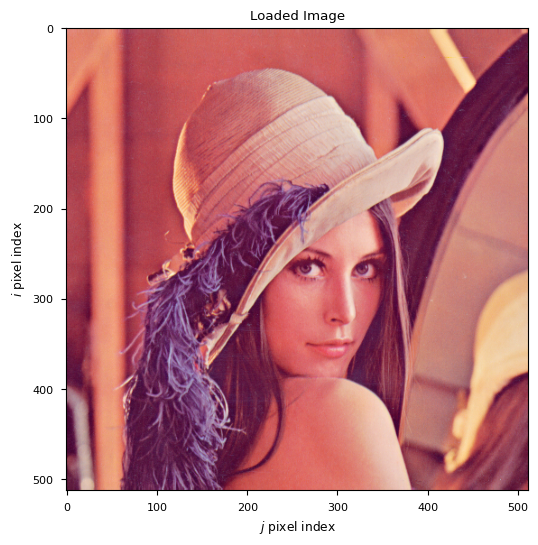

In [6]:
# Load an image
image = Image.open('lena.png')
fig = plt.figure(figsize=(6, 6))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax.imshow(image)
    ax.set_title('Loaded Image')
    ax.set_xlabel('$j$ pixel index')
    ax.set_ylabel('$i$ pixel index')
plt.show()


In Python, a raster image is represented as a multi-dimensional NumPy array. Each element of this array corresponds to a pixel in the image. The shape of the array provides information about the image's dimensions and color channels. For instance, an image with the shape (height, width, 3) indicates a typical RGB image with three color channels. In our case we have:

In [7]:
image_array = np.array(image)
print(f"Shape of the image array: {image_array.shape}")

Shape of the image array: (512, 512, 3)


Each pixel in a raster image is typically represented by a combination of color values. In a **24-bit RGB** color scheme, each color channel (Red, Green, Blue) is represented by 8 bits, allowing for $2^8 = 256$ levels of intensity.

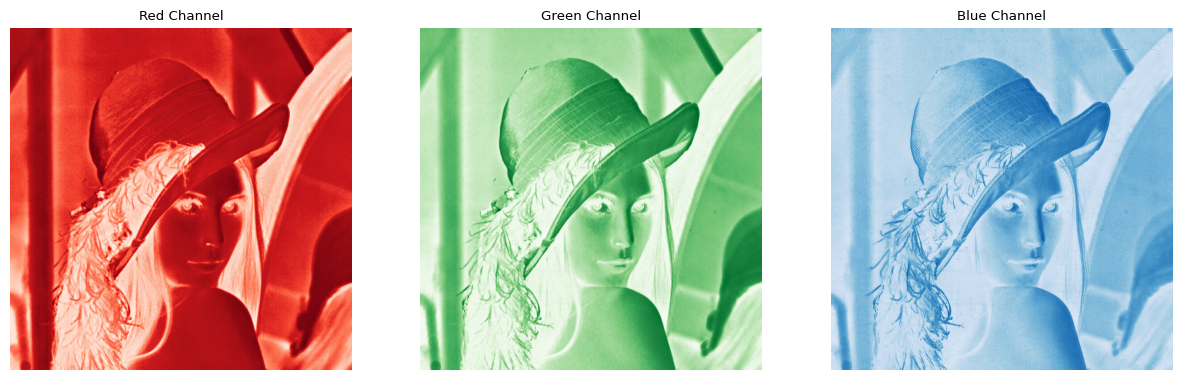

In [8]:
# Separate the channels
red_channel = image_array[:,:,0]
green_channel = image_array[:,:,1]
blue_channel = image_array[:,:,2]

# Display each channel
fig = plt.figure(figsize=(5*3, 5))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(131)
    ax.imshow(red_channel, cmap='Reds', vmax=255)
    ax.set_title('Red Channel')
    ax.axis('off')

    ax = fig.add_subplot(132)
    ax.imshow(green_channel, cmap='Greens', vmax=255)
    ax.set_title('Green Channel')
    ax.axis('off')

    ax = fig.add_subplot(133)
    ax.imshow(blue_channel, cmap='Blues', vmax=255)
    ax.set_title('Blue Channel')
    ax.axis('off')

plt.show()

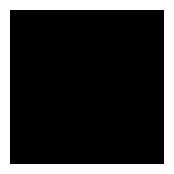

RGB: 0, 0, 0
BIN: 000000000000000000000000
HEX: #000000


In [9]:
# @title RGB 24-bit widget

import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to convert RGB to HEX
def rgb_to_hex(r, g, b):
    return "#{:02x}{:02x}{:02x}".format(r, g, b)

# Function to display the color and its values
def display_color(change):
    clear_output(wait=True)
    display(widget_box)  # Redisplay the widgets
    r, g, b = slider_r.value, slider_g.value, slider_b.value
    hex_color = rgb_to_hex(r, g, b)
    plt.figure(figsize=(2, 2))
    plt.imshow(np.array([[[r/255, g/255, b/255]]]))
    plt.axis('off')
    plt.show()
    print(f"RGB: {r}, {g}, {b}")
    print(f"BIN: {r:08b}{g:08b}{b:08b}")
    print(f"HEX: {hex_color}")

# Creating RGB sliders
slider_r = widgets.IntSlider(value=0, min=0, max=255, description='Red:', continuous_update=False)
slider_g = widgets.IntSlider(value=0, min=0, max=255, description='Green:', continuous_update=False)
slider_b = widgets.IntSlider(value=0, min=0, max=255, description='Blue:', continuous_update=False)

# Observing the sliders
slider_r.observe(display_color, names='value')
slider_g.observe(display_color, names='value')
slider_b.observe(display_color, names='value')

# Grouping the sliders for display
widget_box = widgets.VBox([slider_r, slider_g, slider_b])

# Displaying the widgets
display(widget_box)

# Initial display
display_color(None)


### Dataset ispection and pre-processing

Let’s look how many images we have:

In [66]:
print(f"Train Images:{train_images.shape}")
print(f"Train Labels:{len(train_labels)}")
print(f"Test Images:{test_images.shape}")
print(f"Test Labels:{len(test_labels)}")

Train Images:(60000, 28, 28)
Train Labels:60000
Test Images:(10000, 28, 28)
Test Labels:10000


Thus we have 60k images for the training and 10k for the test (86%-14% split).

Now let see what there is inside this database by randomly plotting 36 pictures:

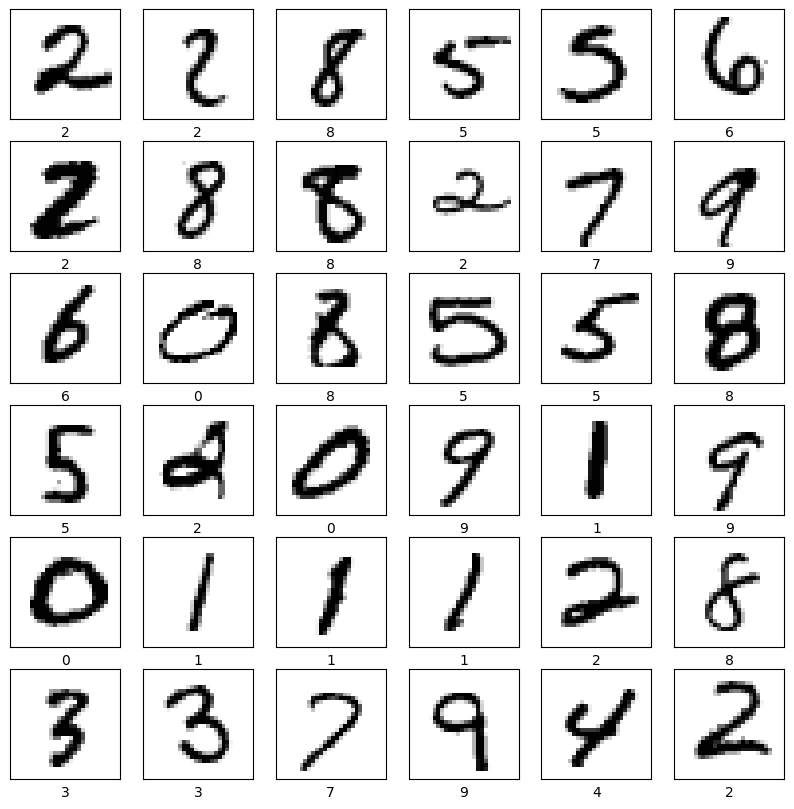

In [67]:
# set a proper figure dimension
plt.figure(figsize=(10,10))
# pick 36 random digits in range 0-59999
# inner bound is inclusive, outer bound exclusive
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    # show images using a binary color map (i.e. Black and White only)
    plt.imshow(train_images[image_ind], cmap=plt.cm.binary)
    # set the image label
    plt.xlabel(train_labels[image_ind])

### Pre-Processing

As discussed in the previous lesson, neural networks perform better when using floating-point numbers that are within the interval $[0,1]$. Since our data is in RGB format and assumes integer values between 0 and 255, we perform the following normalization:

In [68]:
# from range 0-255 to 0-1
train_images = (train_images / 255.).astype(np.float32)
test_images = (test_images /255.).astype(np.float32)

*Label encoding*

In classification tasks for neural networks, each label is transformed into a vector representing all possible classes, called **one-hot** or **one-vs-all encoding**.
In the case of digit recognition (0 through 9), this means converting each digit into a 10-element vector.

Here's a brief explanation of how this encoding works:

Each digit is represented by a 10-element vector.
All elements of the vector are initially set to 0.
The position corresponding to the digit is set to 1, and the rest remain 0.
For example:

* The digit '0' is encoded as [1, 0, 0, 0, 0, 0, 0, 0, 0, 0].
* The digit '1' is encoded as [0, 1, 0, 0, 0, 0, 0, 0, 0, 0].
* And so on, up to the digit '9', which is encoded as [0, 0, 0, 0, 0, 0, 0, 0, 0, 1].


In [77]:
encoder = LabelBinarizer()
encoder.classes_ = np.arange(10)

train_labels_encoded = encoder.transform(train_labels)
test_labels_encoded = encoder.transform(test_labels)

## Model 1: Handwritten digit recognition

### First Try: Let's apply what we learned

Now it's time to build the model!
We are going to use a keras sequential model (as usual) with three different layers. This model represents a feed-forward Fully Connected Neural Network (one that passes values from left to right).

In [78]:
def build_model_1(shape_img: tuple, num_class: int) -> tf.keras.models.Sequential:
    """
    Build a the first possible architecture for our neural network model.
    Args:
        shape_img (tuple): The shape of the input images (height, width, channels).
        num_class (int): The number of classes for the classification task.

    Returns:
        tf.keras.models.Sequential: A Keras Sequential model.
    """
    model = tf.keras.models.Sequential(
        [

            # Convert 2D image data to 1D
            tf.keras.layers.Flatten(input_shape=shape_img, name="flattening_layer"),
            # Dense hidden layer with ReLU activation
            tf.keras.layers.Dense(128, activation='relu', name="hidden_layer_1"),
            # Output layer for classification
            tf.keras.layers.Dense(num_class, activation='softmax', name="output_layer"),
        ]
    )
    return model


Let's call the function to build our model.

In [79]:
model_1 = build_model_1(
    train_images.shape[1:],  # image shape
    10 # number of digits (i.e 0, 1, 2, 3, 4, 5, 6 ,7 , 8, 9)
    )

#### Model Summary and Structure Visualization

Let's examine the summary of our compiled model and visualize its architecture.

**Layer 1 (input)**: This is our input layer and it consists of 784 neurons. We use the flatten layer with an input shape of $(28, 28, 1)$ to denote that our input should come in that shape. The flattening means that our layer will reshape the $(28, 28, 1)$ array into a vector of 784 neurons, so that each pixel will be associated with one neuron. Note: This is the input layer, so 0 parameters have to be trained.

**Layer 2 (hidden)**: This is our first and only hidden layer. The term *dense* denotes that this layer will be fully connected, with each neuron from the previous layer connecting to each neuron of this layer. It has 128 neurons and uses the rectified linear unit (ReLU) activation function.

- Number of parameters in the first hidden layer weights ($\mathbf{w}_{h1}$): $784 \times 128 = 100352$
- Number of parameters in the first hidden layer biases ($\mathbf{b}_{h1}$): $1 \times 128 = 128$

**Layer 3 (output)**: This is our output layer and is also a dense layer. It has 10 neurons that we will look at to determine our model's output. Each neuron represents the probability of a given image belonging to one of the 10 different classes. The activation function *softmax* is used on this layer to calculate a probability distribution for each class. This means the value of any neuron in this layer will be between 0 and 1, where 1 represents a high probability of the image being in that class.

- Number of parameters in the output layer weights ($\mathbf{w}_{o}$): $128 \times 10 = 1280$
- Number of parameters in the output layer biases ($\mathbf{b}_{o}$): $10 \times 1 = 10$

This results in a total of $(100352 + 128) + (1280 + 10) = 101770$ degrees of freedom (dofs) within our model.


In [80]:
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flattening_layer (Flatten)  (None, 784)               0         
                                                                 
 hidden_layer_1 (Dense)      (None, 128)               100480    
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


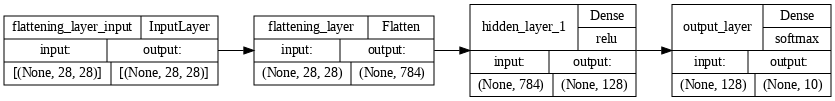

In [81]:
tf.keras.utils.plot_model(
    model=model_1, rankdir="LR", dpi=72, show_shapes=True, show_layer_activations=True
)

#### Model Compilation

Now we will compile our neural network model. Model compilation involves defining key components, such as the loss function, optimizer, learning rate, and metrics.

##### Loss Function

For our classification task, similar to the first binary model shown in Lab 2, we use the Categorical Crossentropy loss function. This loss function is suitable for multi-class classification problems where the classes are mutually exclusive, meaning each entry belongs to precisely one class.

The Categorical Crossentropy loss function calculates the loss by comparing the model's predicted probability distribution $ P $ for each class with the actual distribution $ Y $. The formula for this loss function is:

$ \text{Categorical Crossentropy} = -\sum_{i=1}^{C} y_i \log(p_i) $

where $ C $ is the number of classes, $ y_i $ is a binary indicator (0 or 1) of whether class $ i $ is the correct classification, and $ p_i $ is the predicted probability of the class $ i $.

The loss is the sum of the negative log probabilities of the correct class across all samples in the dataset. This function penalizes incorrect predictions more heavily, thereby guiding the model towards more accurate predictions.

In [82]:
loss = losses.CategoricalCrossentropy()

##### Optimizer

We use the *Adam* optimizer, a popular choice for training neural networks. The [Adam optimization algorithm](https://doi.org/10.48550/arXiv.1412.6980) is a neural network-specific adaptation of the [Stochastic Gradient Descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) method.

In [83]:
optimizer = optimizers.Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

##### Metrics

Metrics are functions needed to measure the behavior of our model. There are many to choose from depending on the task of the model. For our case:

- **Accuracy**: This metric measures the overall classification accuracy of the model. It is calculated as the ratio of correct predictions to the total number of samples.


$ \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} $

In [93]:
metrics = [
    tf.keras.metrics.CategoricalAccuracy(),
]

#### Training
In training, we define two key parameters:

In [101]:
batch_size = 32
epochs = 10

* **Batch Size**: It specifies the number of training examples used in each iteration. A smaller batch size updates the model more frequently, while a larger one may improve training efficiency but requiring more volatile memory (RAM).

* **Epochs**: Each epoch represents one pass through the entire training dataset. It controls how many times the model iterates over the data, influencing convergence and potential overfitting.

Let's (finally) start the training process.

In [102]:
with strategy.scope():
    # These initial lines of code are repeated because they need to be defined
    # inside the parallelization context to efficiently utilize the GPU/TPU.

    # Step 1: Building the Model
    model_1 = build_model_1(train_images.shape[1:], 10)

    # Step 2: Compiling the Model
    loss = losses.CategoricalCrossentropy()
    optimizer = optimizers.Adam(
        learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08
    )
    metrics = [
        tf.keras.metrics.CategoricalAccuracy(),
    ]
    model_1.compile(
        optimizer,
        loss,
        metrics,
    )

    # Step 3: Training the Model
    history = model_1.fit(
        train_images,
        train_labels_encoded,
        batch_size,
        epochs,
        validation_data=(
            test_images,
            test_labels_encoded,
        ),  # Validation set
        verbose=1,  # 0 = silent, 1 = progress bar, 2 = one line per epoch
    )

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2391 - categorical_accuracy: 0.9299 - val_loss: 0.2348 - val_categorical_accuracy: 0.9348
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1636 - categorical_accuracy: 0.9547 - val_loss: 0.1639 - val_categorical_accuracy: 0.9570
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1454 - categorical_accuracy: 0.9613 - val_loss: 0.1533 - val_categorical_accuracy: 0.9595
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1348 - categorical_accuracy: 0.9648 - val_loss: 0.1870 - val_categorical_accuracy: 0.9597
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1235 - categorical_accuracy: 0.9674 - val_loss: 0.1598 - val_categorical_accuracy: 0.9651
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1153 - categorical_accuracy: 0.9704 - val_loss: 0.1805 - val_categorical_accuracy:

### Plots training and results

In [103]:
# @title Ausiliar plot function


def plot_training(
    ax,
    ax_twin,
    history,
    metric="root_mean_squared_error",
    metric_label="RMSE",
    halflife=25,
):
    """
    Plot training history with specified metric.

    Args:
        ax (Matplotlib Axis): The main plot axis.
        ax_twin (Matplotlib Axis): The twinned plot axis.
        history (Pandas DataFrame): Training history data.
        metric (str): The name of the metric to plot.
        metric_label (str): Label for the metric on the plot.
        halflife (int): Exponential moving average halflife for smoothing.

    Returns:
        None
    """
    ax.plot(history.index, history[metric], color="k", ls="-", alpha=0.25)
    a1 = ax.plot(
        history.index,
        history[metric].ewm(halflife=halflife).mean(),
        color="k",
        ls="-",
        label=metric_label + " (train)",
    )
    ax.plot(history.index, history["val_" + metric], color="k", ls="--", alpha=0.25)
    a2 = ax.plot(
        history.index,
        history["val_" + metric].ewm(halflife=halflife).mean(),
        color="k",
        ls="--",
        label=metric_label + " (test)",
    )
    ax_twin.plot(history.index, history["loss"], color="r", ls="-", alpha=0.25)
    l1 = ax_twin.plot(
        history.index,
        history["loss"].ewm(halflife=halflife).mean(),
        color="r",
        ls="-",
        label="Loss (train)",
    )
    ax_twin.plot(history.index, history["val_loss"], color="r", ls="--", alpha=0.25)
    l2 = ax_twin.plot(
        history.index,
        history["val_loss"].ewm(halflife=halflife).mean(),
        color="r",
        ls="--",
        label="Loss (test)",
    )
    ax.set_xlabel("Epochs [-]")
    ax.set_ylabel(metric_label + " [-]")
    ax_twin.set_ylabel(metric_label + "Loss [-]")
    ax_twin.legend(
        a1 + a2 + l1 + l2,
        [
            metric_label + " (train)",
            metric_label + " (test)",
            "Loss (train)",
            "Loss (test)",
        ],
        loc="upper right",
    )
    metric_data = np.concatenate(
        [
            history[metric].ewm(halflife=halflife).mean().values,
            history["val_" + metric].ewm(halflife=halflife).mean().values,
        ]
    )
    lb, ub = [np.percentile(metric_data, 0.5), np.percentile(metric_data, 99.5)]
    delta = ub - lb
    ax.set_ylim([lb - 0.05 * delta, ub + 0.05 * delta])
    loss_data = np.concatenate(
        [
            history["loss"].ewm(halflife=halflife).mean().values,
            history["val_loss"].ewm(halflife=halflife).mean().values,
        ]
    )
    lb, ub = [np.percentile(loss_data, 0.5), np.percentile(loss_data, 99.5)]
    delta = ub - lb
    ax_twin.set_ylim([lb - 0.05 * delta, ub + 0.05 * delta])

# Define classnames for improved readability
class_names = ['Zero', 'One', 'Two', 'Three', 'Four',
            'Five', 'Six', 'Seven', 'Eight', 'Nine']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [104]:
# Plot traing
training_history_try1 = pd.DataFrame(history.history)

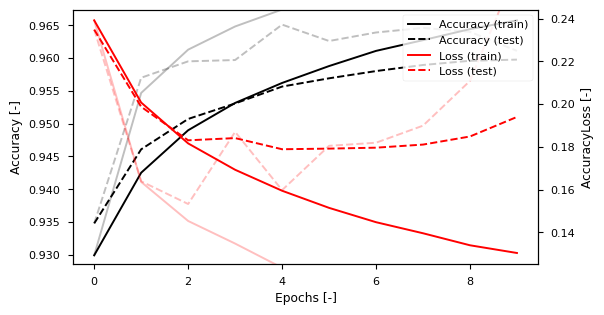

In [107]:
fig = plt.figure(figsize=(6, 3.3))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax_twin = ax.twinx()
    plot_training(
        ax,
        ax_twin,
        training_history_try1,
        metric="categorical_accuracy",
        metric_label="Accuracy",
        halflife=20,
    )
    # ax.set_yscale("log")
    # ax_twin.set_yscale("log")
plt.show()

In [142]:
predictions = model_1.predict(test_images)

313/313 [==============================] - 1s 4ms/step


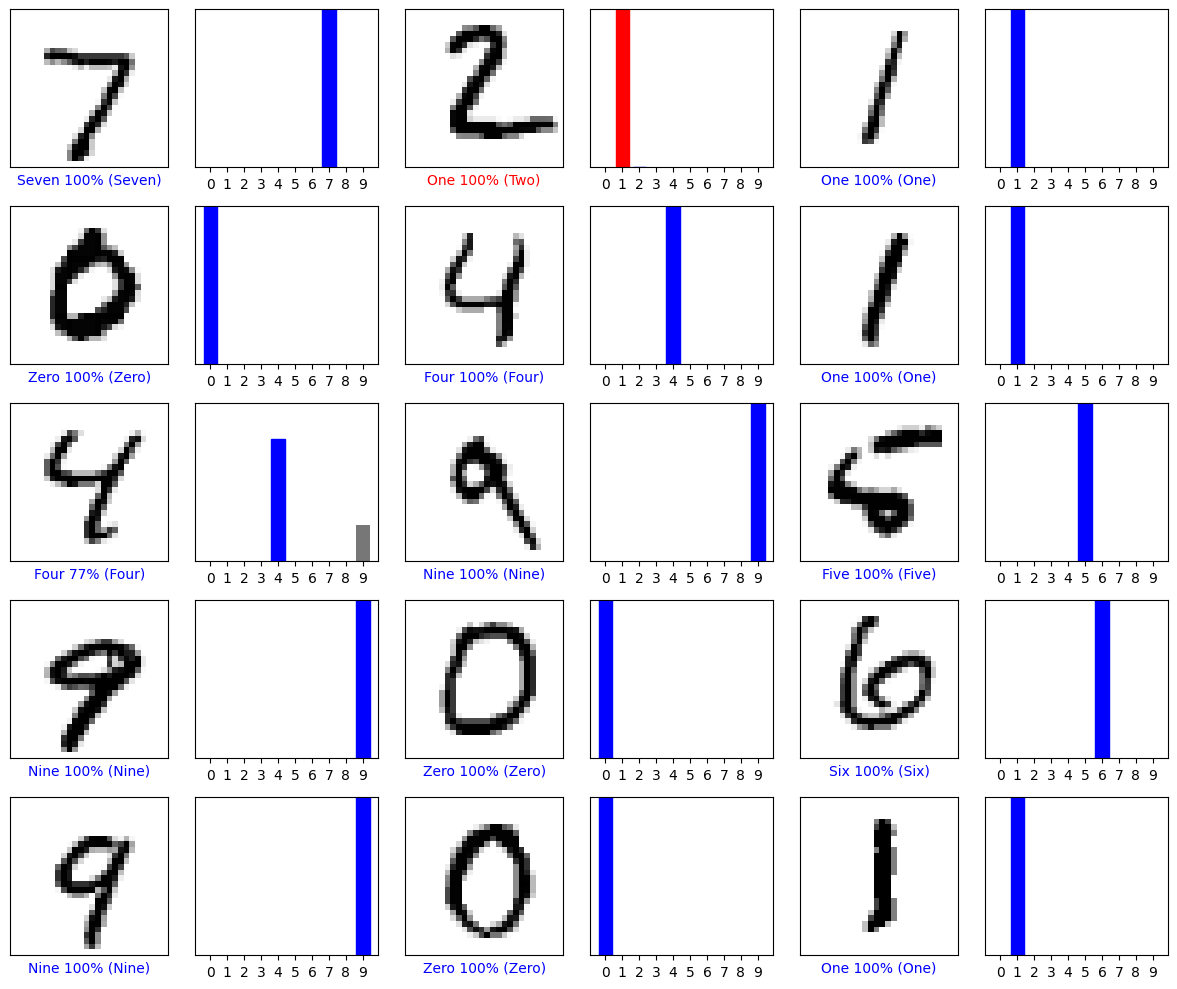

In [143]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, np.squeeze(test_images))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

### Second Try: Data Augmetation

Let's try to reduce the *overfitting* with the *data augmatation*.

**Data augmentation** is a technique used in machine learning and deep learning to increase the diversity of your training dataset without actually collecting new data. This is particularly useful in tasks like image classification, where obtaining a large dataset can be challenging and expensive.

The fundamental idea behind data augmentation is to apply a series of random but realistic transformations to the existing data to create additional, varied training examples. These transformations should change the data in ways that could naturally occur, so the model learns to generalize better and becomes more robust to slight variations it might encounter in real-world data.

For images, common data augmentation techniques include:
- **Rotation**: Rotating the image by a certain angle.
- **Translation**: Shifting the image horizontally or vertically.
- **Rescaling**: Zooming in or out on the image.
- **Flipping**: Mirroring the image horizontally or vertically.
- **Cropping**: Taking a random crop of the image.
- **Changing Brightness or Contrast**: Adjusting the image's brightness or contrast.
- **Adding Noise**: Introducing random pixel noise to the image.

In [124]:
def build_model_2(shape_img: tuple, num_class: int) -> tf.keras.models.Sequential:
    """
    Build a the second possible architecture for our neural network model.
    Args:
        shape_img (tuple): The shape of the input images (height, width, channels).
        num_class (int): The number of classes for the classification task.

    Returns:
        tf.keras.models.Sequential: A Keras Sequential model.
    """
    model = tf.keras.models.Sequential(
        [
            # Augmetation
            layers.RandomZoom(height_factor=(0.0, 0.3)),
            layers.RandomRotation(factor=(-0.25, 0.25)),
            # Convert 2D image data to 1D
            layers.Flatten(name="flattening_layer"),
            # Dense hidden layer with ReLU activation
            layers.Dense(128, activation='relu', name="hidden_layer_1"),
            # Output layer for classification
            tf.keras.layers.Dense(num_class, activation='softmax', name="output_layer"),
        ]
    )
    model.build(input_shape=(None, shape_img[0], shape_img[1]) )
    return model


Let's call the function to build our model.

In [125]:
model_2 = build_model_2(
    train_images.shape[1:],  # image shape
    10 # number of digits (i.e 0, 1, 2, 3, 4, 5, 6 ,7 , 8, 9)
    )

#### Model Summary and Structure Visualization


In [126]:
model_2.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom_3 (RandomZoom)  (None, 28, 28)            0         
                                                                 
 random_rotation_3 (RandomR  (None, 28, 28)            0         
 otation)                                                        
                                                                 
 flattening_layer (Flatten)  (None, 784)               0         
                                                                 
 hidden_layer_1 (Dense)      (None, 128)               100480    
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

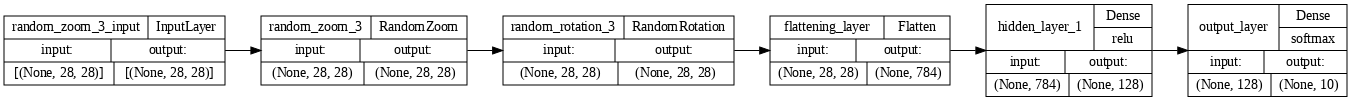

In [127]:
tf.keras.utils.plot_model(
    model=model_2, rankdir="LR", dpi=72, show_shapes=True, show_layer_activations=True
)

#### Model Compilation

##### Loss Function


In [128]:
loss = losses.CategoricalCrossentropy()

##### Optimizer


In [129]:
optimizer = optimizers.Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

##### Metrics


In [130]:
metrics = [
    tf.keras.metrics.CategoricalAccuracy(),
]

#### Training
In training, we define two key parameters:

In [131]:
batch_size = 32
epochs = 10

* **Batch Size**: It specifies the number of training examples used in each iteration. A smaller batch size updates the model more frequently, while a larger one may improve training efficiency but requiring more volatile memory (RAM).

* **Epochs**: Each epoch represents one pass through the entire training dataset. It controls how many times the model iterates over the data, influencing convergence and potential overfitting.

Let's (finally) start the training process.

In [132]:
with strategy.scope():
    # These initial lines of code are repeated because they need to be defined
    # inside the parallelization context to efficiently utilize the GPU/TPU.

    # Step 1: Building the Model
    model_2 = build_model_2(train_images.shape[1:], 10)

    # Step 2: Compiling the Model
    loss = losses.CategoricalCrossentropy()
    optimizer = optimizers.Adam(
        learning_rate=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08
    )
    metrics = [
        tf.keras.metrics.CategoricalAccuracy(),
    ]
    model_2.compile(
        optimizer,
        loss,
        metrics,
    )

    # Step 3: Training the Model
    history = model_2.fit(
        train_images,
        train_labels_encoded,
        batch_size,
        epochs,
        validation_data=(
            test_images,
            test_labels_encoded,
        ),  # Validation set
        verbose=1,  # 0 = silent, 1 = progress bar, 2 = one line per epoch
    )

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 2.2809 - categorical_accuracy: 0.1350 - val_loss: 1.7552 - val_categorical_accuracy: 0.3493
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 2.2716 - categorical_accuracy: 0.1401 - val_loss: 1.7159 - val_categorical_accuracy: 0.4226
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 2.2678 - categorical_accuracy: 0.1399 - val_loss: 1.8318 - val_categorical_accuracy: 0.3557
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 2.2652 - categorical_accuracy: 0.1424 - val_loss: 1.6890 - val_categorical_accuracy: 0.4005
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 2.2655 - categorical_accuracy: 0.1417 - val_loss: 1.7011 - val_categorical_accuracy: 0.3627
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 2.2652 - categorical_accuracy: 0.1410 - val_loss: 1.7545 - val_categorical_accuracy:

### Plots training and results

In [137]:
# Plot traing
training_history_try2 = pd.DataFrame(history.history)

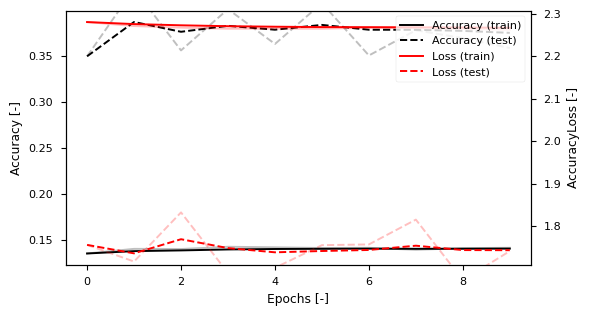

In [139]:
fig = plt.figure(figsize=(6, 3.3))
with plt.style.context("seaborn-v0_8-paper"):
    ax = fig.add_subplot(111)
    ax_twin = ax.twinx()
    plot_training(
        ax,
        ax_twin,
        training_history_try2,
        metric="categorical_accuracy",
        metric_label="Accuracy",
        halflife=20,
    )
    # ax.set_yscale("log")
    # ax_twin.set_yscale("log")
plt.show()

In [140]:
predictions = model_2.predict(test_images)

313/313 [==============================] - 1s 3ms/step


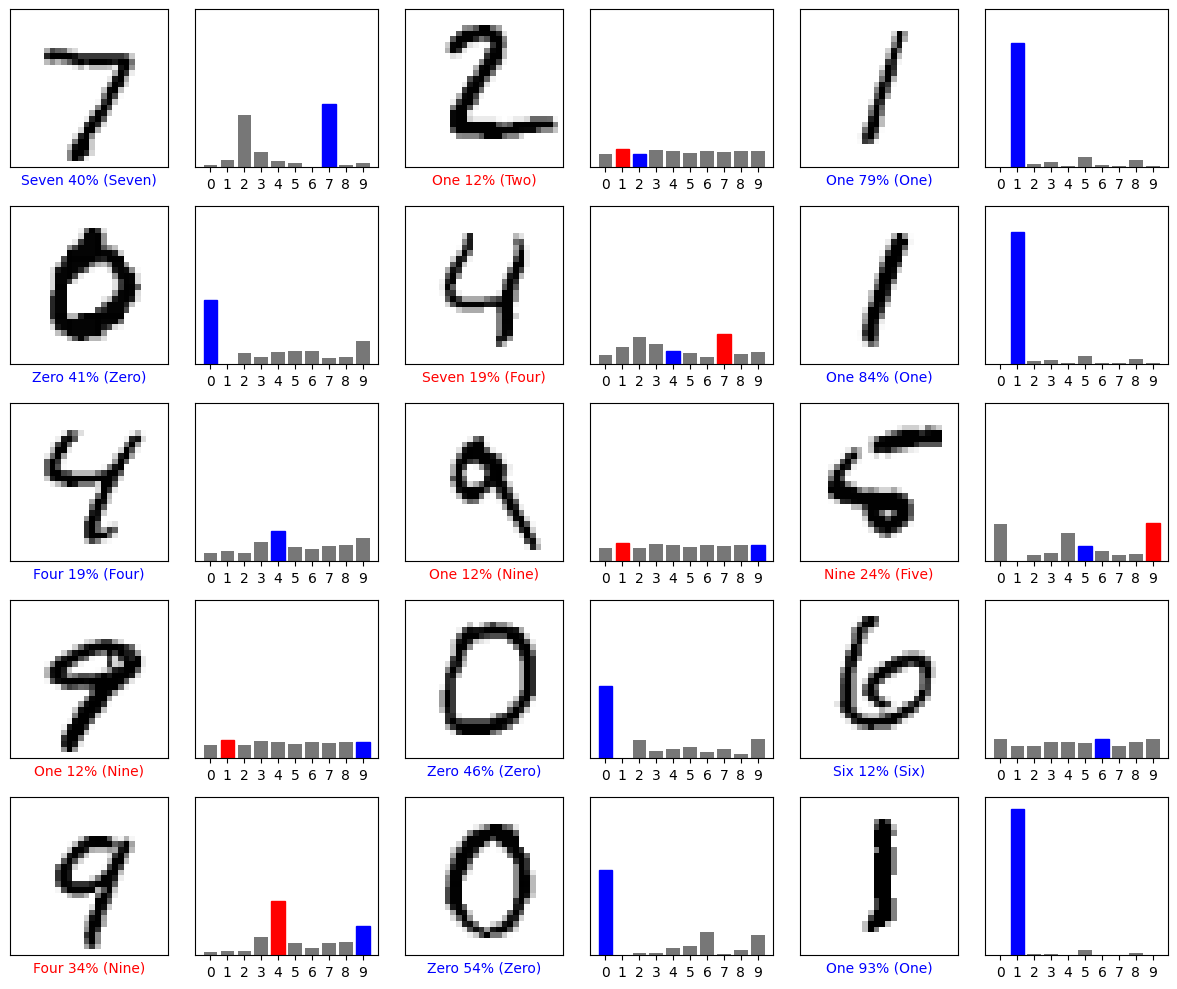

In [141]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, np.squeeze(test_images))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

### Exercise: Use MNIST Fashion Dataset

Train a NN model using the MNIST Fashion Dataset this time.

steps:
- Download dataset
- Ispect data
- Design a architecture
- Chose a loss function and metrics
- Compile the model
- Training
- Visualize the result

#### Dataset sownload
For this tutorial we will use the MNIST Fashion Dataset. This is a dataset that is included in keras.

This dataset includes 60,000 images for training and 10,000 images for validation/testing.

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist  # load dataset

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()  # split into tetsing and training

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Do the rest